# Visualizing Spectra with SIMPLE 

### Brief Overview of Querying SIMPLE

##### To better understand querying, we recommend you run through the QueryDemo.ipynb notebook before you begin here. Once you feel ready regarding querying, come back here for some fun with visualization. 

##### In this notebook, we will mostly use the AstroDBUtils package to query the database. Find more information on this package here: https://astrodbkit.readthedocs.io/en/latest/#exploring-the-schema

In [195]:
import astropy.units as u
import astropy.constants as const
from astropy.io import fits
from specutils import Spectrum

from sqlalchemy import and_, or_
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
plt.rcParams['font.family'] = 'serif'

In [196]:
# Load in the database
from astrodb_utils import load_astrodb
from simple import REFERENCE_TABLES

SCHEMA_PATH = "simple/schema.yaml" 
recreatedb = False #Set to True or False
db = load_astrodb(
     "SIMPLE.sqlite", 
     recreatedb=recreatedb,  
     reference_tables=REFERENCE_TABLES, 
     felis_schema=SCHEMA_PATH
     )

### Visualization Methods

#### Lets try first plotting a single spectra from a single source

##### In this use case, we are looking to plot the spectra for the object with the most spectra available in SIMPLE. Using what we just learned, we can use SQL to query the database for this answer.

In [197]:
from specutils import Spectrum
import matplotlib.pyplot as plt
from astropy.io import fits
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
plt.rcParams['font.family'] = 'serif'

##### Lets do an inventory check of '2MASS J04151954-0935066' using db.inventory (https://astrodbkit.readthedocs.io/en/latest/astrodb.html#astrodbkit.astrodb.Database.inventory)

In [198]:
results = db.inventory("2MASS J04151954-0935066")

##### Now lets parse through that dictionary output to only view the spectra associated with 2MASS 0415

In [199]:
for i in range(len(results['Spectra'])):
    print(results['Spectra'][i])

{'access_url': 'https://s3.amazonaws.com/bdnyc/IRS/0415-0935%20%28LL2%29.txt', 'original_spectrum': None, 'local_spectrum': '$BDNYC_spectra/IRS/0415-0935 (LL2).txt', 'regime': 'mir', 'telescope': 'Spitzer', 'instrument': 'IRS', 'mode': 'Missing', 'observation_date': datetime.datetime(2005, 9, 6, 0, 0), 'comments': None, 'reference': 'PID3259', 'other_references': None}
{'access_url': 'https://s3.amazonaws.com/bdnyc/IRS/0415-0935.txt', 'original_spectrum': None, 'local_spectrum': '$BDNYC_spectra/IRS/0415-0935.txt', 'regime': 'mir', 'telescope': 'Spitzer', 'instrument': 'IRS', 'mode': 'Missing', 'observation_date': datetime.datetime(2005, 9, 7, 0, 0), 'comments': None, 'reference': 'PID3431', 'other_references': None}
{'access_url': 'https://bdnyc.s3.amazonaws.com/IRS/2MASS+J04151954-0935066.fits', 'original_spectrum': 'https://bdnyc.s3.amazonaws.com/IRS/0415-0935_IRS_spectrum.dat', 'local_spectrum': None, 'regime': 'mir', 'telescope': 'Spitzer', 'instrument': 'IRS', 'mode': 'SL', 'obser

##### Lets first plot up just one of these spectra, you can directly copy the link from the dictionary and use Spectrum to visualize the data

Text(0.5, 1.0, 'JWST NIRSpec Spectrum of 2MASS J04151954-0935066')

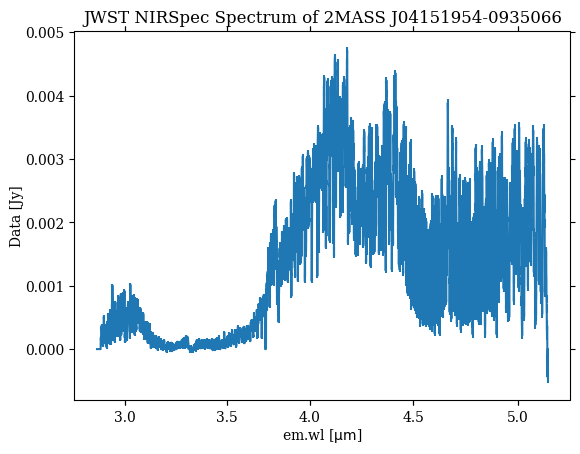

In [200]:
jwst = Spectrum.read('https://bdnyc.s3.us-east-1.amazonaws.com/JWST/NIRSpec/jw02124-o059_s00001_nirspec_f290lp-g395h-s200a1-subs200a1_x1d_manual.fits')
jwst.plot()
plt.title('JWST NIRSpec Spectrum of 2MASS J04151954-0935066')

Text(0.5, 1.0, 'FIRE Spectrum of 2MASS J04151954-0935066')

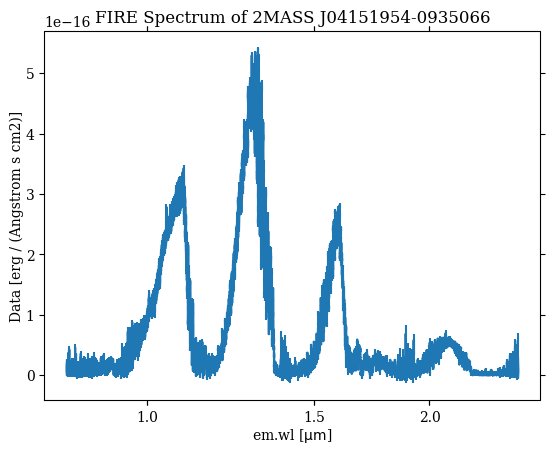

In [201]:
fire = Spectrum.read('https://bdnyc.s3.us-east-1.amazonaws.com/FIRE/FIRE_0415-0935.fits')
fire.plot()
plt.title('FIRE Spectrum of 2MASS J04151954-0935066')

Text(0.5, 1.0, 'AKARI Spectrum of 2MASS J04151954-0935066')

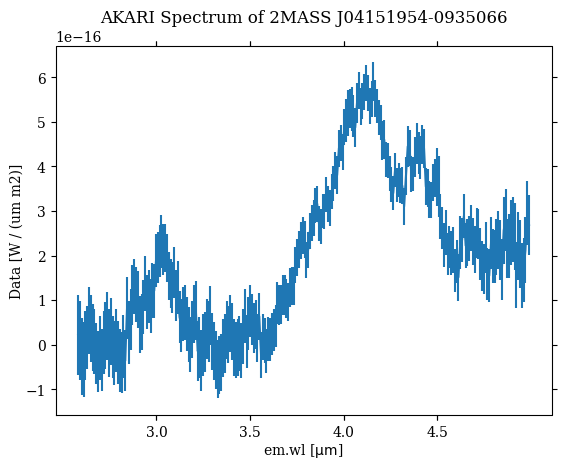

In [202]:
akari = Spectrum.read('https://bdnyc.s3.us-east-1.amazonaws.com/AKARI_2MASS%2BJ04151954-0935066_2007-08-23.fits')
akari.plot()
plt.title('AKARI Spectrum of 2MASS J04151954-0935066')

##### The Spectrum.read function automatically picks up on the units within the fits file, and you can see from each of these that the flux is at different units so to be able to plot them all together we would need to do some unit conversion to better visualize them. Lets do that next!

In [203]:
# Converting the outlier spectra to the same units (JWST NIRSpec Spectra is in Jy)
jwst_wavelength, flux = jwst.spectral_axis, jwst.flux
target_unit = u.W / (u.um * u.m**2)  # Desired flux unit
 
jwst_flux_converted = flux.to(target_unit, equivalencies=u.spectral_density(jwst_wavelength))

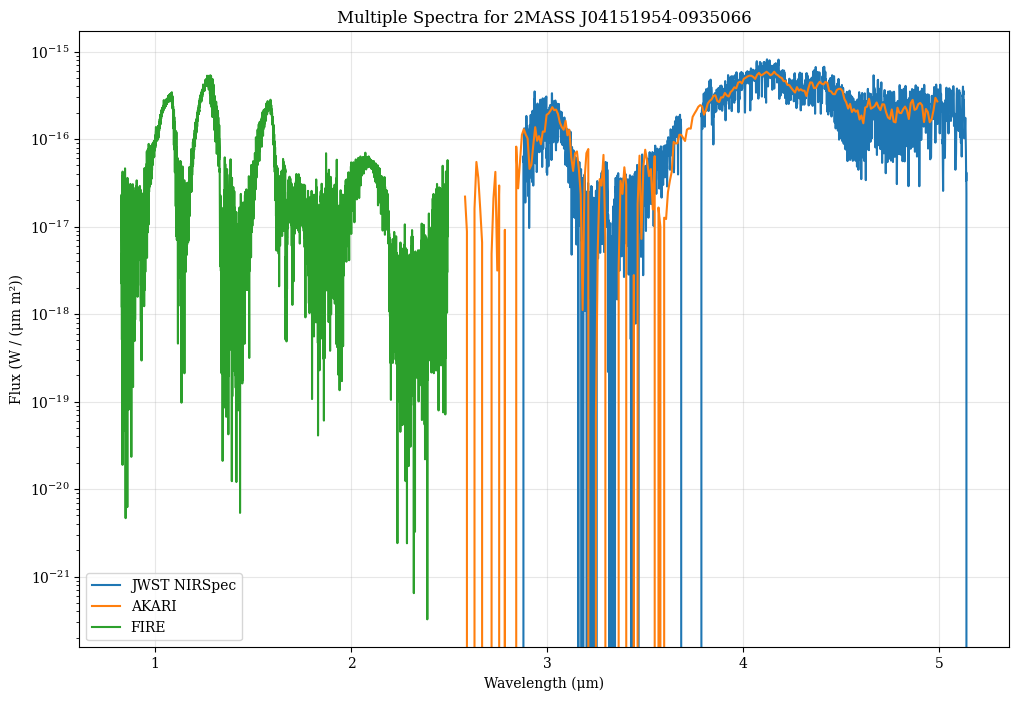

In [204]:
plt.figure(figsize=(12, 8))

plt.plot(jwst_wavelength, jwst_flux_converted, label='JWST NIRSpec')
plt.plot(akari.spectral_axis, akari.flux, label='AKARI')
plt.plot(fire.spectral_axis, fire.flux, label='FIRE')

# Add labels and title
plt.xlabel('Wavelength (μm)')
plt.ylabel('Flux (W / (μm m²))')
plt.title('Multiple Spectra for 2MASS J04151954-0935066')
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)

# Display the plot
plt.show()

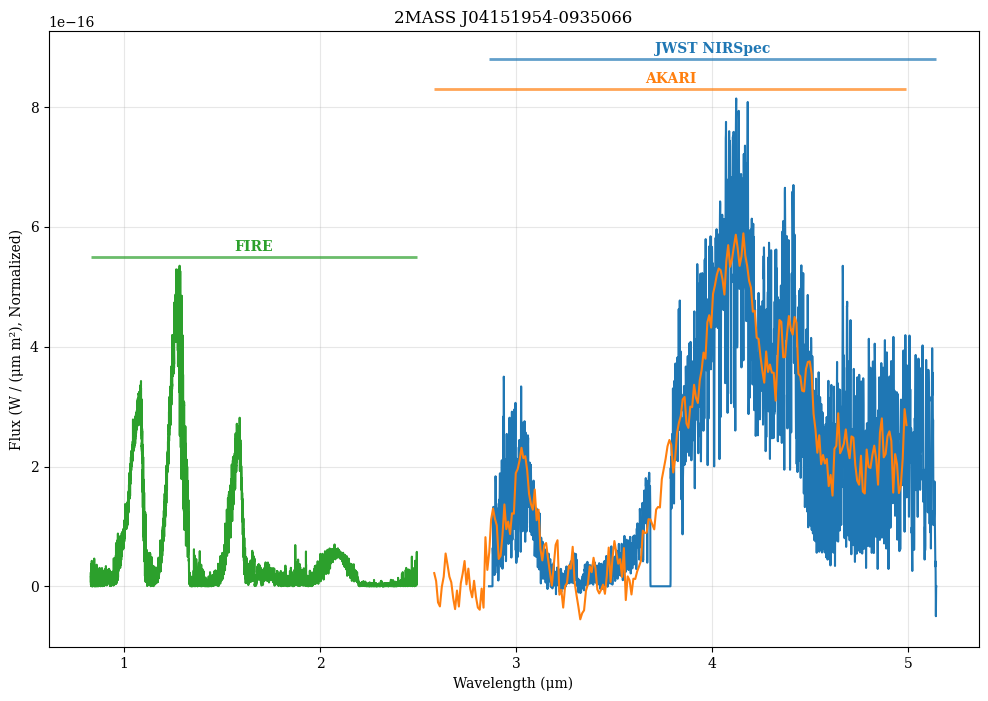

In [205]:
plt.figure(figsize=(12, 8))

plt.plot(jwst_wavelength, jwst_flux_converted, label='JWST NIRSpec')
plt.plot(akari.spectral_axis, akari.flux, label='AKARI')
plt.plot(fire.spectral_axis, fire.flux, label='FIRE')

# Add labels and title
plt.xlabel('Wavelength (μm)')
plt.ylabel('Flux (W / (μm m²), Normalized)')
plt.title('2MASS J04151954-0935066')
plt.grid(True, alpha=0.3)

jwst_range = [jwst_wavelength.value.min(), jwst_wavelength.value.max()]
akari_range = [akari.spectral_axis.value.min(), akari.spectral_axis.value.max()]
fire_range = [fire.spectral_axis.value.min(), fire.spectral_axis.value.max()]

# Annotate the plot with Matplotlib's hlines and text functions

#JWST
plt.hlines(8.8e-16, jwst_range[0], jwst_range[1], 
           colors=plt.gca().lines[0].get_color(), linestyles='-', linewidth=2, alpha=0.7)
plt.text((jwst_range[0] + jwst_range[1])/2, 8.9e-16, 'JWST NIRSpec', 
         color=plt.gca().lines[0].get_color(), fontweight='bold', ha='center')

#AKARI
plt.hlines(8.3e-16, akari_range[0], akari_range[1], 
           colors=plt.gca().lines[1].get_color(), linestyles='-', linewidth=2, alpha=0.7)
plt.text((akari_range[0] + akari_range[1])/2, 8.4e-16, 'AKARI', 
         color=plt.gca().lines[1].get_color(), fontweight='bold', ha='center')

#FIRE 
plt.hlines(0.55e-15, fire_range[0], fire_range[1], 
           colors=plt.gca().lines[2].get_color(), linestyles='-', linewidth=2, alpha=0.7)
plt.text((fire_range[0] + fire_range[1])/2, 0.56e-15, 'FIRE', 
         color=plt.gca().lines[2].get_color(), fontweight='bold', ha='center')

plt.show()

#### Now lets try plotting spectra from multiple sources using a couple different metrics we can decide on within SIMPLE

##### To further understand what different ways you can query obects you can reference the schema in simple/schema.yaml and for a visual reference the github documentation: https://github.com/SIMPLE-AstroDB/SIMPLE-db/tree/main/docs

In [206]:
# Create a query to join ModeledParameters and Spectra tables
# This will find all spectra for sources with T_eff between 1100-1200K
spectra_temp_query = """
SELECT 
    mp.source, 
    mp.parameter,
    mp.value,
    s.regime, 
    s.instrument, 
    s.telescope, 
    s.access_url

FROM ModeledParameters mp
JOIN Spectra s ON mp.source = s.source
WHERE mp.parameter = 'T eff' 
    AND mp.value BETWEEN 1100 AND 1300
ORDER BY mp.value, mp.source, s.regime
"""

# Execute the query
low_temp = db.sql_query(spectra_temp_query, fmt='pandas')
print(f"Found {len(low_temp)} spectra for sources with T_eff between 1100-1300K within SIMPLE.") #How many spectra did we find?
print(f"Found {len(low_temp['source'].unique())} unique sources.") #How many unique sources did we find?
print(f"First ten sources:\n{low_temp['source'].unique()[:10]}") #Lets print the first ten sources

Found 213 spectra for sources with T_eff between 1100-1300K within SIMPLE.
Found 60 unique sources.
First ten sources:
['2MASS J03255322+0425406' '2MASS J07420130+2055198'
 '2MASS J08304878+0128311' '2MASS J15031961+2525196'
 '2MASS J23565477-1553111' '2MASSI J1546271-332511'
 '2MASSI J2339101+135230' '2MASS J07584037+3247245'
 '2MASS J08592547-1949268' '2MASS J09083803+5032088']


In [207]:
low_temp

,source,parameter,value,regime,instrument,telescope,access_url
0,2MASS J03255322+0425406,T eff,1100.0,nir,SpeX,IRTF,https://s3.amazonaws.com/bdnyc/spex-prism_SDSS...
1,2MASS J07420130+2055198,T eff,1100.0,nir,SpeX,IRTF,https://s3.amazonaws.com/bdnyc/spex-prism_SDSS...
2,2MASS J08304878+0128311,T eff,1100.0,nir,SpeX,IRTF,https://s3.amazonaws.com/bdnyc/spex-prism_SDSS...
3,2MASS J15031961+2525196,T eff,1100.0,mir,IRS,Spitzer,https://bdnyc.s3.amazonaws.com/IRS/2MASS+J1503...
4,2MASS J15031961+2525196,T eff,1100.0,mir,IRS,Spitzer,https://s3.amazonaws.com/bdnyc/IRS/1503%2B2525...
...,...,...,...,...,...,...,...
208,SDSS J151643.01+305344.4,T eff,1300.0,mir,IRS,Spitzer,https://bdnyc.s3.amazonaws.com/IRS/2MASS+J1516...
209,SIMP J013656.5+093347.3,T eff,1300.0,mir,IRS,Spitzer,https://bdnyc.s3.amazonaws.com/IRS/SIMP+J01365...
210,SIMP J013656.5+093347.3,T eff,1300.0,nir,XShooter,ESO VLT,https://bdnyc.s3.amazonaws.com/xshooter/IPMS01...
211,SIMP J013656.5+093347.3,T eff,1300.0,nir,WFC3,HST,https://bdnyc.s3.amazonaws.com/WFC3/SIMP0136.csv


Skipped 2MASS J15031961+2525196: W / (um m2)
Skipped 2MASS J07584037+3247245: W / (um m2)


        Use Spectrum instead. [astrodbkit.spectra]


Skipped 2MASS J08592547-1949268: erg / (A s cm2)
Skipped 2MASS J09083803+5032088: erg / (A s cm2)


        Use Spectrum instead. [astrodbkit.spectra]


Skipped 2MASS J09083803+5032088: erg / (A s cm2)
Skipped 2MASS J21392676+0220226: erg / (A s cm2)


\wavsamp version for S13.0, 2005 Sep 13, D. Shupe                                [astropy.io.fits.card]
\processing time 13:37:15 PST 09/13/2005                                         [astropy.io.fits.card]
\wavsamp software version 5.1 (Wed Apr 20 08:45:04 PDT 2005)                     [astropy.io.fits.card]
\character channelID = 0                                                         [astropy.io.fits.card]
\COMMENT ========== Keywords from PROFILE table file below ==========            [astropy.io.fits.card]
                                                                                 [astropy.io.fits.card]
FCON_UNC = 0.000000                                                              [astropy.io.fits.card]
        Use Spectrum instead. [astrodbkit.spectra]


Skipped 2MASS J21392676+0220226: erg / (A s cm2)
Skipped 2MASS J21392676+0220226: W / (um m2)
Skipped 2MASS J21392676+0220226: W / (um m2)
Skipped 2MASS J00001354+2554180: W / (um m2)
Skipped 2MASS J08300825+4828482: W / (um m2)


        Use Spectrum instead. [astrodbkit.spectra]
        Use Spectrum instead. [astrodbkit.spectra]


Skipped 2MASS J16322911+1904407: W / (um m2)
Skipped 2MASS J16322911+1904407: W / (um m2)
Skipped 2MASS J16322911+1904407: W / (um m2)
Skipped 2MASS J02550357-4700509: W / (um m2)
Skipped 2MASS J02550357-4700509: W / (um m2)
Skipped 2MASS J02550357-4700509: W / (um m2)
Skipped 2MASS J02550357-4700509: W / (um m2)
Skipped 2MASS J02550357-4700509: W / (um m2)
Skipped 2MASS J02550357-4700509: W / (um m2)
Skipped SDSS J083717.21-000018.0: W / (um m2)
Skipped 2MASS J15150083+4847416: W / (um m2)


        Use Spectrum instead. [astrodbkit.spectra]


Skipped 2MASS J15150083+4847416: W / (um m2)
Skipped 2MASS J15150083+4847416: W / (um m2)
Skipped 2MASS J00001354+2554180: W / (um m2)
Skipped 2MASS J05591914-1404488: W / (um m2)
Skipped 2MASS J05591914-1404488: W / (um m2)
Skipped 2MASS J21392676+0220226: W / (um m2)


\wavsamp version for S13.0, 2005 Sep 13, D. Shupe                                [astropy.io.fits.card]
\processing time 13:37:15 PST 09/13/2005                                         [astropy.io.fits.card]
\wavsamp software version 5.1 (Wed Apr 20 08:45:04 PDT 2005)                     [astropy.io.fits.card]
\character channelID = 0                                                         [astropy.io.fits.card]
\COMMENT ========== Keywords from PROFILE table file below ==========            [astropy.io.fits.card]
                                                                                 [astropy.io.fits.card]
FCON_UNC = 0.000000                                                              [astropy.io.fits.card]
        Use Spectrum instead. [astrodbkit.spectra]


Skipped 2MASS J21392676+0220226: W / (um m2)
Skipped 2MASS J21392676+0220226: W / (um m2)
Skipped 2MASS J21392676+0220226: W / (um m2)
Skipped 2MASS J21442847+1446077: W / (um m2)
Skipped 2MASS J21513839-4853542: W / (um m2)
Skipped 2MASS J21513839-4853542: W / (um m2)
Skipped 2MASS J22443167+2043433: W / (um m2)
Skipped 2MASS J22443167+2043433: W / (um m2)
Skipped 2MASS J22443167+2043433: W / (um m2)
Skipped 2MASS J22443167+2043433: W / (um m2)
Skipped 2MASS J11555389+0559577: W / (um m2)


        Use Spectrum instead. [astrodbkit.spectra]


Skipped 2MASS J23254530+4251488: W / (um m2)
Skipped 2MASS J23254530+4251488: W / (um m2)


        Use Spectrum instead. [astrodbkit.spectra]


Skipped 2MASS J02572581-3105523: W / (um m2)
Skipped 2MASS J02572581-3105523: W / (um m2)
Skipped 2MASS J12545393-0122474: W / (um m2)
Skipped 2MASS J12545393-0122474: W / (um m2)
Skipped 2MASS J08251968+2115521: W / (um m2)


        Use Spectrum instead. [astrodbkit.spectra]


Skipped 2MASS J08251968+2115521: erg / (A s cm2)
Skipped 2MASS J08251968+2115521: erg / (A s cm2)
Skipped 2MASS J00001354+2554180: erg / (A s cm2)
Skipped 2MASS J12545393-0122474: erg / (A s cm2)
Skipped 2MASS J12545393-0122474: erg / (A s cm2)
Skipped 2MASS J01033203+1935361: W / (um m2)


        Use Spectrum instead. [astrodbkit.spectra]


Skipped 2MASS J01033203+1935361: W / (um m2)
Skipped 2MASS J01033203+1935361: W / (um m2)
Skipped 2MASS J00303013-1450333: W / (um m2)
Skipped 2MASS J15232263+3014562: W / (um m2)
Skipped 2MASS J15232263+3014562: W / (um m2)


        Use Spectrum instead. [astrodbkit.spectra]


Skipped 2MASS J10101480-0406499: erg / (A s cm2)
Skipped 2MASS J08300825+4828482: erg / (A s cm2)


        Use Spectrum instead. [astrodbkit.spectra]


Skipped 2MASS J05591914-1404488: erg / (A s cm2)
Skipped 2MASS J05591914-1404488: erg / (A s cm2)
Skipped 2MASS J13314894-0116500: erg / (A s cm2)
Skipped 2MASS J13314894-0116500: erg / (A s cm2)
Skipped 2MASS J13314894-0116500: erg / (Angstrom s cm2)


        Use Spectrum instead. [astrodbkit.spectra]


Skipped 2MASS J15203974+3546210: erg / (Angstrom s cm2)
Skipped 2MASS J11181292-0856106: erg / (Angstrom s cm2)
Skipped 2MASS J11181292-0856106: erg / (Angstrom s cm2)
Skipped 2MASS J06244595-4521548: erg / (Angstrom s cm2)


        Use Spectrum instead. [astrodbkit.spectra]


Skipped 2MASS J06244595-4521548: erg / (A s cm2)
Skipped 2MASS J06244595-4521548: erg / (A s cm2)
Skipped 2MASS J06244595-4521548: erg / (A s cm2)
Skipped 2MASS J06244595-4521548: erg / (A s cm2)
Skipped 2MASS J16322911+1904407: W / (um m2)
Skipped 2MASS J16322911+1904407: W / (um m2)


        Use Spectrum instead. [astrodbkit.spectra]


Skipped 2MASS J16322911+1904407: W / (um m2)
Skipped 2MASS J20025073-0521524: erg / (A s cm2)


        Use Spectrum instead. [astrodbkit.spectra]


Skipped 2MASS J20025073-0521524: erg / (A s cm2)
Skipped 2MASS J04390101-2353083: erg / (A s cm2)


        Use Spectrum instead. [astrodbkit.spectra]


Skipped 2MASS J04390101-2353083: erg / (A s cm2)
Skipped 2MASS J04390101-2353083: erg / (A s cm2)
Skipped 2MASS J04390101-2353083: erg / (A s cm2)
Skipped 2MASS J02550357-4700509: erg / (A s cm2)
Skipped 2MASS J02550357-4700509: erg / (A s cm2)
Skipped 2MASS J02550357-4700509: erg / (A s cm2)
Skipped 2MASS J02550357-4700509: erg / (A s cm2)
Skipped 2MASS J02550357-4700509: erg / (A s cm2)
Skipped 2MASS J02550357-4700509: erg / (A s cm2)
Skipped 2MASS J04390101-2353083: erg / (A s cm2)


        Use Spectrum instead. [astrodbkit.spectra]


Skipped 2MASS J04390101-2353083: erg / (A s cm2)
Skipped 2MASS J04390101-2353083: erg / (A s cm2)
Skipped 2MASS J04390101-2353083: erg / (A s cm2)


        Use Spectrum instead. [astrodbkit.spectra]


Skipped 2MASS J21481633+4003594: erg / (A s cm2)
Skipped 2MASS J21481633+4003594: W / (um m2)
Skipped 2MASS J15232263+3014562: W / (um m2)


        Use Spectrum instead. [astrodbkit.spectra]


Skipped 2MASS J15232263+3014562: W / (um m2)
Skipped 2MASS J15261405+2043414: W / (um m2)
Skipped 2MASS J15261405+2043414: W / (um m2)
Skipped 2MASSI J2254188+312349: W / (um m2)
Skipped SDSS J151643.01+305344.4: W / (um m2)
Skipped SIMP J013656.5+093347.3: W / (um m2)
Skipped SIMP J013656.5+093347.3: W / (um m2)
Skipped SIMP J013656.5+093347.3: W / (um m2)


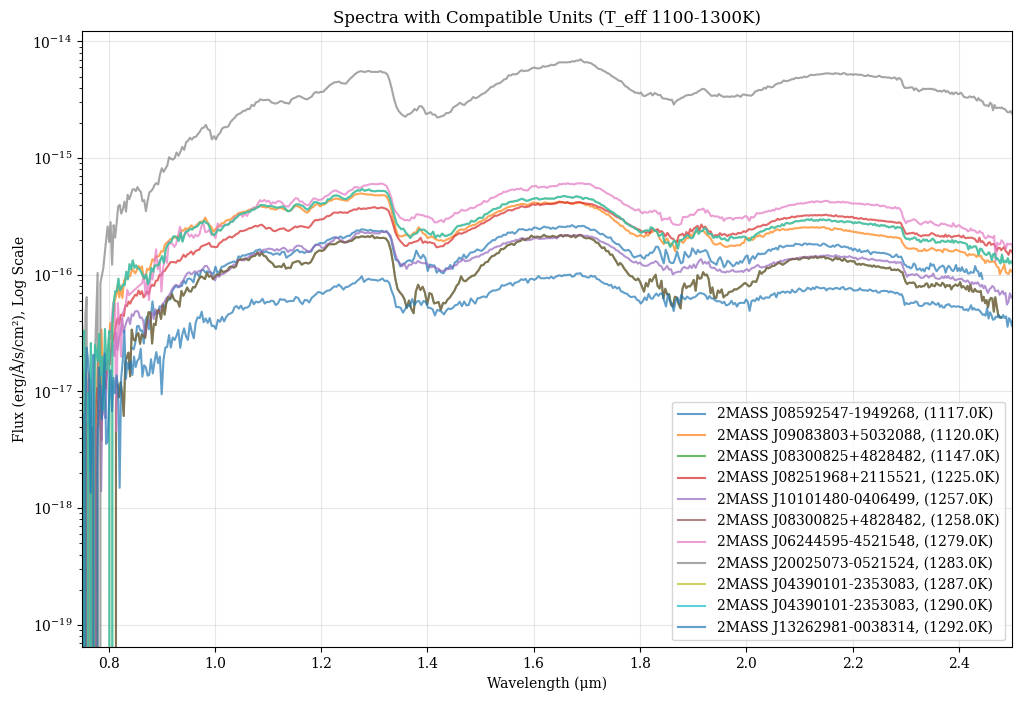

In [210]:
import matplotlib.pyplot as plt
from specutils import Spectrum1D
import astropy.units as u

plt.figure(figsize=(12, 8))

# Loop through spectra
for i in range(len(low_temp)):
    url = low_temp.iloc[i]['access_url']
    source = low_temp.iloc[i]['source']
    temp = low_temp.iloc[i]['value']
    
    if "fits" in url:
        try:
            spec = Spectrum1D.read(url)
            
            # Check if flux can be converted to the target units
            target_unit = u.erg / (u.A * u.s * u.cm**2)
            wavelength = spec.spectral_axis.to(u.um)
            flux = spec.flux.to(target_unit, equivalencies=u.spectral_density(wavelength))
            
            # Only plots if conversion is successful
            plt.plot(wavelength, flux, label=f"{source}, ({temp}K)", alpha=0.7)
            
        except Exception as e:
            print(f"Skipped {source}: {spec.flux.unit if 'spec' in locals() else 'loading failed'}")
            continue

plt.xlabel('Wavelength (μm)')
plt.ylabel('Flux (erg/Å/s/cm²), Log Scale')
plt.title('Spectra with Compatible Units (T_eff 1100-1300K)')
plt.legend()
plt.yscale('log')
plt.xlim(0.75, 2.5)
plt.grid(True, alpha=0.3)
plt.show()



##### Bonus Example! Using SQL_Query (https://astrodbkit.readthedocs.io/en/latest/astrodb.html#astrodbkit.astrodb.Database.sql_query) we can pull out the values for various modelled parameters and visualize them together to get trends in the data. Lets take this example of comparing temperature to mass for objects with recorded modelled parameters for both. 

Found 2692 objects with values for both Temperature and Mass.


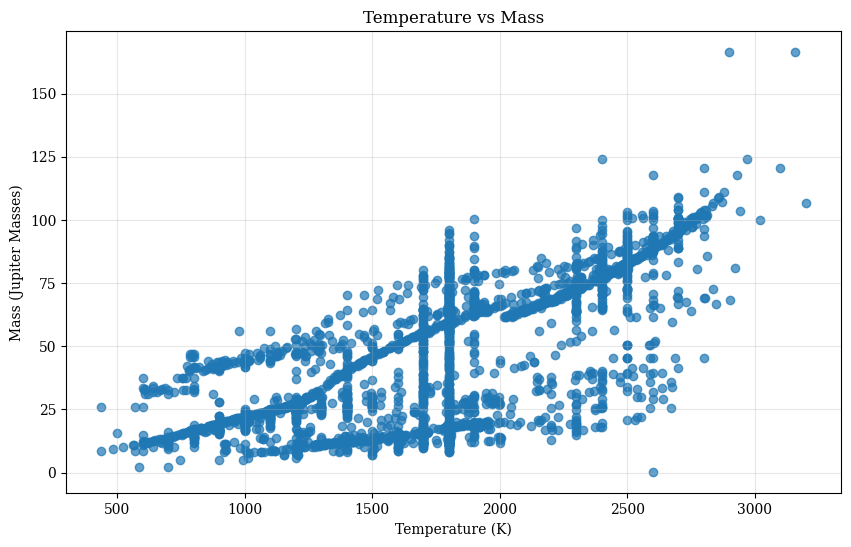

In [209]:
import pandas as pd
import matplotlib.pyplot as plt

# Get data from database
query = """
SELECT 
    s1.source, 
    s1.value as temperature, 
    s2.value as mass
FROM ModeledParameters s1
JOIN ModeledParameters s2 ON s1.source = s2.source
WHERE s1.parameter = 'T eff' AND s2.parameter = 'mass'
"""

# Load data into a table
data = db.sql_query(query, fmt='pandas')
data.columns = ['Source', 'Temperature', 'Mass']
print(f"Found {len(data)} objects with values for both Temperature and Mass.")

# Make the plot
plt.figure(figsize=(10, 6))
plt.scatter(data['Temperature'], data['Mass'], alpha=0.7)

plt.xlabel('Temperature (K)')
plt.ylabel('Mass (Jupiter Masses)')
plt.title('Temperature vs Mass')
plt.grid(True, alpha=0.3)

plt.show()